<a href="https://colab.research.google.com/github/readthroughmyglasses/FYP_QUORA/blob/master/FYP_Quora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Setting the path for data**

In [0]:
!ls '/content/drive/My Drive/FINAL DESTINATION/DATA/'

data_prep.csv  sample_submission.csv  train.csv     word2vec.mdl
questions.csv  test.csv		      word2vec.bin


In [0]:
path = '/content/drive/My Drive/FINAL DESTINATION/DATA/train.csv'

**Importing required packages**

In [0]:
import pandas as pd
import io
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

import re

import gensim

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_multiple_whitespaces, remove_stopwords, stem_text

import spacy

In [0]:
df = pd.read_csv(path,encoding='utf-8').iloc[:,1:]
df.head()

,qid1,qid2,question1,question2,is_duplicate
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


**General description of data**

In [0]:
df.describe()

,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000
mean,217243.942418,220955.655337,0.369198
std,157751.700002,159903.182629,0.482588
min,1.000000,2.000000,0.000000
25%,74437.500000,74727.000000,0.000000
50%,192182.000000,197052.000000,0.000000
75%,346573.500000,354692.500000,1.000000
max,537932.000000,537933.000000,1.000000


**Copy file of data**

In [0]:
df_prep = pd.read_csv(path).iloc[:,1:]


**Tokenized- removing tags, multiple white spaces, stopwords.**

In [0]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_multiple_whitespaces, remove_stopwords, stem_text
custom_filters = [strip_tags, strip_multiple_whitespaces, remove_stopwords, stem_text]
def get_tokenized_questions(X):
    series = pd.Series(pd.concat([X['question1'], X['question2']]),dtype=str)
    series.dropna()
    for question in series:
        yield preprocess_string(question, custom_filters)
li=[]
for i in get_tokenized_questions(df_prep):
    li.append(i)
tokenized_questions = pd.Series(li)
print(tokenized_questions)

0         [what, step, step, guid, invest, share, market...
1           [what, stori, kohinoor, (koh-i-noor), diamond?]
2         [how, i, increas, speed, internet, connect, vpn?]
3              [why, i, mental, lonely?, how, i, solv, it?]
4         [which, dissolv, water, quikli, sugar,, salt,,...
                                ...                        
808575    [how, keyword, perl, program, languag, latest,...
808576                             [is, true, life, death?]
808577                                       [what', coin?]
808578    [i, have, littl, hairfal, problem, i, want, us...
808579                           [what, like, sex, cousin?]
Length: 808580, dtype: object


**Fasttext embedding**

In [0]:
#@title
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from sklearn import preprocessing
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from smart_open import smart_open 

In [0]:
#@title
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2019-11-03 06:16:26--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.10.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.10.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  91.7MB/s    in 24s     

2019-11-03 06:16:50 (66.0 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
#@title
import smart_open

file = smart_open.open('/root/input/GoogleNews-vectors-negative300.bin.gz', 'rb').read(64)
file


b'3000000 300\n</s> \x00\x00\x94:\x00\x00k\xba\x00\x00\xa79\x00\x00\xc9:\x00\x00\x91:\x00\x00\xb8\xba\x00\x00\x00\xb8\x00\x00\xdc\xb9\x00\x00\x17\xba\x00\x00\x8d:\x00\x00\x86\xba\x00\x00"'

In [0]:
#@title
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'

In [0]:
#@title
import spacy.cli
spacy.cli.download("en_core_web_sm")
from IPython.display import HTML
from smart_open import smart_open
import logging
logging.getLogger('smart_open').setLevel(logging.ERROR)

# step 1: initialize word2vec model with the vocabulary of training data
model_w2v = gensim.models.Word2Vec(tokenized_questions, size=300) 

# step 2: intersect the initialized word2vec model with the pre-trained fasttext model
model_w2v= gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE,binary=True)
# step 3: improve model with transfer-learning using the training data


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#@title
model_w2v.doesnt_match(' love pizza and cheese'.split())

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'love'

**fasttext different method**

In [0]:
#@title

from gensim.models import KeyedVectors

model_2 = Word2Vec(size=300, min_count=1)
model_2.build_vocab(tokenized_questions)
total_examples = model_2.corpus_count
model = KeyedVectors.load_word2vec_format("glove.6B.300d.txt", binary=False)
model_2.build_vocab([list(model.vocab.keys())], update=True)
model_2.intersect_word2vec_format("glove.6B.300d.txt", binary=False, lockf=1.0)
model_2.train(tokenized_questions, total_examples=total_examples, epochs=model_2.iter)

# fit a 2d PCA model to the vectors
X = model_2[model_1.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model_1.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [0]:
#@title
!python -m spacy download en_core_web_lg

**Glove (springboard)**

In [0]:
#@title
## Code to embed questions using the spacy glove pre-trained model

# number of randomly generated OOV vectors
num_oov = 50

# extract all questions from the data set
questions = pd.concat([df_prep['question1'], df_prep['question2']]).values  

# load the spacy pre-trained glove model
nlp = spacy.load('en_core_web_sm')    
    
# create random vectors for OOV tokens
oov = np.random.normal(size=(num_oov, nlp.vocab.vectors_length))
oov = oov / oov.sum(axis=1, keepdims=True)
    
# append the OOV vectors to the end of the spacy glove vectors
vectors = np.zeros((num_vectors + num_oov, nlp.vocab.vectors_length), dtype='float32')
for lex in nlp.vocab:
    if lex.has_vector and lex.vector_norm > 0:
        vectors[lex.rank + 1] = lex.vector / lex.vector_norm 
vectors[num_vectors:, ] = oov   

# convert each question into a set of token ids (indices) which 
# will be used to index the vectors (built above) 
# to fetch the set of word vectors for each question 
questions_as_ids = []
for q in questions:
    q_tokens = nlp(q)
    word_ids = []

    for i, token in enumerate(q_tokens):
        # skip odd spaces from tokenizer
        if token.has_vector and token.vector_norm == 0:
            continue
            
        if token.has_vector:
            word_ids.append(token.rank + 1)
        else:
            # this is an OOV word, pick one of the randomly generated oov vectors
            word_ids.append(token.rank % num_oov + num_vectors)                

    questions_as_ids.append(word_ids)   

**Word2Vec**

In [0]:
#@title
# avoid decoding problems
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
#df = pd.read_csv("/media/eightbit/8bit_5tb/NLP_data/Quora/DuplicateQuestion/quora_duplicate_questions.tsv",delimiter='\t')
 
# encode questions to unicode
df_prep['question1'] = df_prep['question1'].apply(lambda x: str(x))
df_prep['question2'] = df_prep['question2'].apply(lambda x: str(x))

In [0]:
#@title
import gensim

df_prep = df_prep.dropna(subset=['question1','question2'])

questions = list(df_prep['question1']) + list(df_prep['question2'])

# tokenize
c = 0
for question in tqdm(questions):
    questions[c] = list(gensim.utils.tokenize(question, lower=True))
    c += 1

# train model
model = gensim.models.Word2Vec(questions, size=300, workers=16, iter=10, negative=20)

# trim memory
model.init_sims(replace=True)

100%|██████████| 808580/808580 [00:09<00:00, 82483.36it/s]


In [0]:
#@title
# creta a dict 
w2v = dict(zip(model.wv.index2word, model.wv.syn0))
print ("Number of tokens in Word2Vec:", len(w2v.keys()))

# save model
#model.save('/content/drive/My Drive/FINAL DESTINATION/DATA/word2vec1.mdl')
#model.wv.save_word2vec_format('/content/drive/My Drive/FINAL DESTINATION/DATA/word2vec1.bin', binary=True)

Number of tokens in Word2Vec: 29189


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [0]:
#@title
print(w2v['engineering'])

[-0.04573641 -0.09402992 -0.02560878  0.00343344 -0.04908442  0.04047737
  0.01167541 -0.00048786  0.02870229 -0.06145491  0.08226281  0.06003475
  0.06879323  0.0608987   0.04853408 -0.10013288  0.02905212  0.08349629
 -0.01483766 -0.04642613 -0.03398913  0.03458616  0.02970782 -0.03085133
  0.06855069  0.02875181  0.06806219 -0.08835232  0.04277475 -0.00288524
  0.09541886  0.05096545  0.02722085  0.08665435 -0.05889004  0.05549747
 -0.12959126  0.00086157 -0.06134809 -0.02179291 -0.14762938 -0.0009725
  0.03372221  0.00672845 -0.07467321  0.01457527  0.05415056 -0.03780357
  0.01247287 -0.00130038 -0.00448597 -0.06481367  0.08990423 -0.01985391
 -0.05136501  0.06091699 -0.0126251   0.01532643 -0.01518029  0.03495552
 -0.0404532   0.06117247  0.0127008   0.04674635  0.0274637   0.00414363
 -0.05979227 -0.0815677   0.0024141  -0.03202543  0.10236095  0.00739599
 -0.06256265 -0.03133549  0.00142999  0.00096231 -0.1060375  -0.09176059
 -0.03179167  0.07263386  0.11168773 -0.09627811  0.

In [0]:
#@title
word_vectors = model.wv
count = 0
for word in word_vectors.vocab:
    if count<10:
        print(word)
        count += 1
    else:
        break

what
is
the
step
by
guide
to
invest
in
share


In [0]:
#@title
wanted_words = []
count = 0
for word in word_vectors.vocab:
    if count<150:
        wanted_words.append(word)
        count += 1
    else:
        break
wanted_vocab = dict((k, word_vectors.vocab[k]) for k in wanted_words if k in word_vectors.vocab)
wanted_vocab

{'a': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9dd1d0>,
 'about': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9dd828>,
 'am': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9dd278>,
 'an': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9e14e0>,
 'and': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9dd550>,
 'answered': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9e1860>,
 'are': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9ddf28>,
 'ask': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9e1b70>,
 'astrology': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9dd630>,
 'banglore': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9e19b0>,
 'be': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9dd908>,
 'best': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9e18d0>,
 'buy': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9dd8d0>,
 'by': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9c2ac8>,
 'can': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9c2fd0>,
 'canada': <gensim.models.keyedvectors.Vocab at 0x7fdcdc9

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


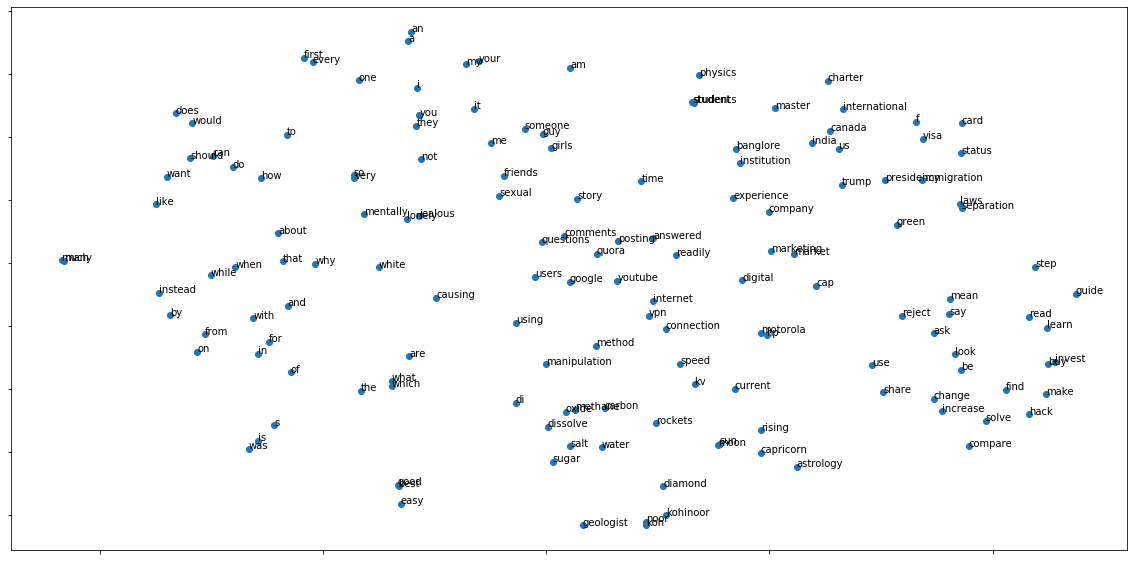

In [0]:
#@title
import sklearn
from sklearn.manifold import TSNE

X = model[wanted_vocab] # X is an array of word vectors, each vector containing 150 tokens
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
Y = tsne_model.fit_transform(X)
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(Y[:, 0], Y[:, 1])
words = list(wanted_vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(Y[i, 0], Y[i, 1]))
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks
_ = plt.show()

In [0]:
#@title
w1 = "phone"
model.wv.most_similar(positive=w1, topn=5)

**Training GLOVE model using Pretrained model in spacy (NO NEED TO RUN THIS SECTION (THE NEXT 4 CELLS)**

In [0]:
#@title
# exctract word2vec vectors
import spacy
nlp = spacy.load('en')
vecs1 = [doc.vector for doc in nlp.pipe(df_prep['question1'], n_threads=50)]
vecs1 =  np.array(vecs1)
df_prep['q1_feats'] = list(vecs1)
  

In [0]:
#@title
vecs2 = [doc.vector for doc in nlp.pipe(df_prep['question2'], n_threads=50)]
vecs2 =  np.array(vecs2)
df_prep['q2_feats'] = list(vecs2)

In [0]:
#@title
df_prep.to_csv('data_prep.csv')

In [0]:
#@title
print(df_prep['q1_feats'].head())

**FEATURE ENGINEERING**

**1. TF-IDF Weights — Term Frequency-Inverse Document Frequency (n-gram) + XGboost**

In [0]:
#@title
# preprocess the questions in the training set 
X_train_tokens = get_tokenized_questions(df_prep)

from sklearn.feature_extraction.text import TfidfVectorizer
pass_through = lambda x:x
tfidf = TfidfVectorizer(analyzer=pass_through , ngram_range=(2,3), max_features=5000)
# compute tf-idf weights for the words in the training set questions
X_tfidf = tfidf.fit_transform(X_train_tokens)

# split into two
# X1_tfidf -> tf-idf weights of first question in question pair and 
# X2_tfidf -> tf-idf weights of second question in question pair
X1_tfidf = X_tfidf[:len(df_prep)]
X2_tfidf = X_tfidf[len(df_prep):]


In [0]:
print(X1_tfidf)
print(X2_tfidf)

  (0, 2289)	0.22745403010877335
  (0, 2753)	0.3018781330638037
  (0, 3979)	0.3338334978169566
  (0, 2372)	0.30555040769953157
  (0, 2026)	0.40733445467254675
  (0, 4226)	0.6910614302293323
  (0, 4849)	0.09402735102694518
  (1, 4242)	0.962542091037636
  (1, 4849)	0.2711322979301717
  (2, 1047)	0.5050693266927511
  (2, 2353)	0.5034354107443473
  (2, 4161)	0.4989205911570359
  (2, 2280)	0.42865412167101713
  (2, 2206)	0.17659786345091882
  (2, 2184)	0.16614705763670598
  (3, 2423)	0.3410194972474573
  (3, 4117)	0.4200603738395541
  (3, 2675)	0.5790499543541552
  (3, 2831)	0.4692948058073205
  (3, 4868)	0.20409117117321549
  (3, 2206)	0.30020402124514367
  (3, 2184)	0.14121919100807864
  (4, 1304)	0.5905664352516559
  (4, 787)	0.5921166492375932
  (4, 4810)	0.4679052765864275
  :	:
  (404283, 79)	0.41175541074725214
  (404283, 4483)	0.3231656032392034
  (404283, 4849)	0.1259654188074263
  (404284, 4849)	1.0
  (404285, 4732)	0.5173133203173494
  (404285, 2496)	0.5065324681747889
  (404285, 

In [0]:
# df_prep['question1'] = df_prep['question1'].apply(lambda x: str(x))
# df_prep['question2'] = df_prep['question2'].apply(lambda x: str(x))

# df_prep = df_prep.dropna(subset=['question1','question2'])

In [0]:
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss
import xgboost as xgb
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
# tfidf_vect_ngram.fit(pd.concat((df_prep['question1'],df_prep['question2'])).unique())
# trainq1_trans = tfidf_vect_ngram.transform(df_prep['question1'].values)
# trainq2_trans = tfidf_vect_ngram.transform(df_prep['question2'].values)

# print(trainq1_trans)

labels = df_prep['is_duplicate'].values
X = scipy.sparse.hstack((X1_tfidf,X2_tfidf))
y = labels
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [0]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)
print('n-gram level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('n-gram level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

n-gram level tf-idf training score: 0.7874282018446503
n-gram level tf-idf validation score: 0.726997890741667
              precision    recall  f1-score   support

           0       0.76      0.91      0.83     83975
           1       0.77      0.52      0.62     49441

    accuracy                           0.77    133416
   macro avg       0.77      0.72      0.73    133416
weighted avg       0.77      0.77      0.75    133416



**Feature computation using the weighted average of pairwise distance metrics**

In [0]:
#@title
from sklearn.metrics import pairwise_distances
# function to compute similarity based on weighted average of pairwise distances
def compute_pairwise_dist(pc1, pc2, w1, w2, method='euclidean'):
    if pc1.size == 0 or pc2.size == 0:
        return np.nan
    dist_mat = pairwise_distances(pc1, pc2, metric=method) 
    return np.average(dist_mat, weights=np.matmul(w1.reshape(-1,1),w2.reshape(-1,1).T))

#cosine similarities
# here X1 and X2 are the embedded versions of the first and second questions in the question-pair data
# and X1_tfidf and X2_tfidf are the tf-idf weights of the first and second questions in the question-pair data
cosine = compute_pairwise_dist(df_prep['q1_feats'], df_prep['q2_feats'], X1_tfidf, X2_tfidf)

#correlation similarities
# here X1 and X2 are the embedded versions of the first and second questions in the question-pair data
# and X1_tfidf and X2_tfidf are the tf-idf weights of the first and second questions in the question-pair data
correlation = compute_pairwise_dist(df_prep['q1_feats'], df_prep['q2_feats'], X1_tfidf, X2_tfidf)

In [0]:
#@title
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df_prep['question1']) + list(df_prep['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
#@title
# exctract word2vec vectors
import spacy
nlp = spacy.load('en')

vecs1 = []
for qu in tqdm(list(df_prep['question1'])):
    doc = nlp(qu) 
    mean_vec = np.zeros([len(doc), 300])
    for word in doc:
        # word2vec
        vec = word.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec += vec * idf
    mean_vec = mean_vec.mean(axis=0)
    vecs1.append(mean_vec)
df_prep['q1_feats'] = list(vecs1)

# **NEW**

In [0]:
!pip install -q jellyfish 

     |████████████████████████████████| 143kB 2.8MB/s 


In [0]:
!pip install -q testfixtures

     |████████████████████████████████| 92kB 2.9MB/s 


In [0]:
!pip install utils

In [0]:
!pip install vocabulary

     |████████████████████████████████| 593kB 4.1MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 112kB 50.2MB/s 
  Created wheel for vocabulary: filename=Vocabulary-1.0.4-cp36-none-any.whl size=12313 sha256=ff227b698cd3f7c695197ae0ecc3596cb378b181106a6c832ed36e408aec4610
  Stored in directory: /root/.cache/pip/wheels/84/0f/09/2191cf9d60966b5581f98c61f21bbc63234057368602c0a6c4
Successfully built vocabulary
ERROR: tensorflow-datasets 1.3.0 has requirement requests>=2.19.0, but you'll have requests 2.13.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.13.0 which is incompatible.
ERROR: google-api-core 1.14.3 has requirement requests<3.0.0dev,>=2.18.0, but you'll have requests 2.13.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.21.0
    Uninstalling 

In [0]:
!pip install -q sklearn.cross_validation

ERROR: Could not find a version that satisfies the requirement sklearn.cross_validation (from versions: none)
ERROR: No matching distribution found for sklearn.cross_validation


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import sys
import os 
import re
import string
from math import*
import jellyfish
import gensim
from gensim.models import *
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('universal_tagset')
nltk.download('punkt')

import utils
import vocabulary

#import xgboost as xgb
#from tqdm import tqdm
#import spacy

import sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

from importlib import reload
from textblob import TextBlob
reload(utils)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<module 'utils' from '/usr/local/lib/python3.6/dist-packages/utils/__init__.py'>

In [0]:
import re
import time
import itertools
import numpy as np
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
import timeit

# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=True):
    word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset): return word
    else: return "<unk>" # unknown token

def canonicalize_words(words, **kw):
    return [canonicalize_word(word, **kw) for word in words]

##
# Data loading functions
import nltk
import vocabulary

def get_corpus(name="brown"):
    return nltk.corpus.__getattr__(name)

def build_vocab(corpus, V=10000):
    token_feed = (canonicalize_word(w) for w in corpus.words())
    vocab = vocabulary.Vocabulary(token_feed, size=V)
    return vocab

def sents_to_tokens(sents, vocab):
    """Returns an flattened list of the words in the sentences, with normal padding."""
    padded_sentences = (["<s>"] + s + ["</s>"] for s in sents)
    # This will canonicalize words, and replace anything not in vocab with <unk>
    return np.array([canonicalize_word(w, wordset=vocab.wordset)
                     for w in flatten(padded_sentences)], dtype=object)

def get_train_test_sents(corpus, split=0.8, shuffle=True):
    """Get train and test sentences.
    Args:
      corpus: nltk.corpus that supports sents() function
      split (double): fraction to use as training set
      shuffle (int or bool): seed for shuffle of input data, or False to just
      take the training data as the first xx% contiguously.
    Returns:
      train_sentences, test_sentences ( list(list(string)) ): the train and test
      splits
    """
    sentences = np.array(corpus.sents(), dtype=object)
    fmt = (len(sentences), sum(map(len, sentences)))
    print ("Loaded %d sentences (%g tokens)" % fmt)

    if shuffle:
        rng = np.random.RandomState(shuffle)
        rng.shuffle(sentences)  # in-place
    train_frac = 0.8
    split_idx = int(train_frac * len(sentences))
    train_sentences = sentences[:split_idx]
    test_sentences = sentences[split_idx:]

    fmt = (len(train_sentences), sum(map(len, train_sentences)))
    print ("Training set: %d sentences (%d tokens)" % fmt)
    fmt = (len(test_sentences), sum(map(len, test_sentences)))
    print ("Test set: %d sentences (%d tokens)" % fmt)

    return train_sentences, test_sentences

def preprocess_sentences(sentences, vocab):
    """Preprocess sentences by canonicalizing and mapping to ids.
    Args:
      sentences ( list(list(string)) ): input sentences
      vocab: Vocabulary object, already initialized
    Returns:
      ids ( array(int) ): flattened array of sentences, including boundary <s>
      tokens.
    """
    # Add sentence boundaries, canonicalize, and handle unknowns
    words = ["<s>"] + flatten(s + ["<s>"] for s in sentences)
    words = [canonicalize_word(w, wordset=vocab.word_to_id)
             for w in words]
    return np.array(vocab.words_to_ids(words))

##
# Use this function
def load_corpus(name, split=0.8, V=10000, shuffle=0):
    """Load a named corpus and split train/test along sentences."""
    corpus = get_corpus(name)
    vocab = build_vocab(corpus, V)
    train_sentences, test_sentences = get_train_test_sents(corpus, split, shuffle)
    train_ids = preprocess_sentences(train_sentences, vocab)
    test_ids = preprocess_sentences(test_sentences, vocab)
    return vocab, train_ids, test_ids

##
# Use this function
def batch_generator(ids, batch_size, max_time):
    """Convert ids to data-matrix form."""
    # Clip to multiple of max_time for convenience
    clip_len = ((len(ids)-1) / batch_size) * batch_size
    input_w = ids[:clip_len]     # current word
    target_y = ids[1:clip_len+1]  # next word
    # Reshape so we can select columns
    input_w = input_w.reshape([batch_size,-1])
    target_y = target_y.reshape([batch_size,-1])

    # Yield batches
    for i in xrange(0, input_w.shape[1], max_time):
      yield input_w[:,i:i+max_time], target_y[:,i:i+max_time]

## -----------------------------------------------------------
## New helper function added for Open Classification Project
## -----------------------------------------------------------
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

## Clean String
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`-]", " ", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

## Taking care of the stop words and stemming
## Keep punctuation
def preprocess_stop_stem(text, punc=False, stem=False, stop=False, sent=False):
    
    # Remove punctuations
    if punc:
        regex = re.compile('[%s]' % re.escape(string.punctuation))
        text = regex.sub('', text)
        
    tokens = word_tokenize(text) 
    if stop:
        stop = stopwords.words('english')
        tokens =[word for word in tokens if word not in stop]
        tokens = [word.lower() for word in tokens]
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
    if sent:
        tokens = ' '.join(tokens)
    return tokens

## Preprocess newsgroup data
## Cleaning, Cut or padd with given length
## Input: list of data from newsgroup library
## Output: list of data with cleaned and cut/padded strings
#Preprocessing for Doc2Vec 
def preprocess_doc(doc):
    if type(doc) is str:
        doc = clean_str((doc))
        new_doc = preprocess_stop_stem(doc, punc=False, stop=True, sent=True, stem=False)
    elif math.isnan(doc):
        new_doc = "empty string"
    elif isinstance(doc, float):
        new_doc = "empty string"
    return new_doc

def get_train_test_docs(docs, labels, split = 0.8, shuffle=True):
    """"
    Args:
      docs: a list of sample docs
      split (double): fraction to use as training set
      shuffle (int or bool): seed for shuffle of input data, or False to just
      take the training data as the first xx% contiguously.
    Returns:
      train_docs, test_docs ( list(docs in string) ): the train and test
      splits
    """
    
    docs = np.array(docs, dtype=object)
    labels = np.array(labels)
    fmt = (len(docs), sum(map(len, docs)))
    print ("Loaded %d docs (%g tokens)" % fmt)
    
    if shuffle:
        np.random.seed(10)
        shuffle_indices = np.random.permutation(np.arange(len(labels)))
        docs = docs[shuffle_indices]
        labels = labels[shuffle_indices]
    train_frac = 0.8
    split_idx = int(train_frac * len(labels))
    train_docs = docs[:split_idx]
    train_labels = labels[:split_idx]
    test_docs = docs[split_idx:]
    test_labels = labels[split_idx:]

    fmt = (len(train_docs), sum(map(len, train_docs)))
    print ("Training set: %d docs (%d tokens)" % fmt)
    fmt = (len(test_docs), sum(map(len, test_docs)))
    print ("Test set: %d docs (%d tokens)" % fmt)

    return train_docs, train_labels, test_docs, test_labels

def get_train_val_docs(docs, labels, split = 0.8, shuffle=True):
    """"
    Args:
      docs: a list of sample docs
      split (double): fraction to use as training set
      shuffle (int or bool): seed for shuffle of input data, or False to just
      take the training data as the first xx% contiguously.
    Returns:
      train_docs, test_docs ( list(docs in string) ): the train and test
      splits
    """
    
    docs = np.array(docs, dtype=object)
    labels = np.array(labels)
    fmt = (len(docs), sum(map(len, docs)))
    print ("Loaded %d docs (%g tokens)" % fmt)
    
    if shuffle:
        np.random.seed(10)
        shuffle_indices = np.random.permutation(np.arange(len(labels)))
        docs = docs[shuffle_indices]
        labels = labels[shuffle_indices]
    train_frac = 0.8
    split_idx = int(train_frac * len(labels))
    train_docs = docs[:split_idx]
    train_labels = labels[:split_idx]
    valid_docs = docs[split_idx:]
    valid_labels = labels[split_idx:]

    fmt = (len(train_docs), sum(map(len, train_docs)))
    print ("Training set: %d docs (%d tokens)" % fmt)
    fmt = (len(valid_docs), sum(map(len, valid_docs)))
    print ("Validation set: %d docs (%d tokens)" % fmt)

    return train_docs, train_labels, valid_docs, valid_labels
    
## Tokenize document and convert ids
## Input: docs in np.array, vocab object
## Return: converted docs np.array
def docs_to_ids(docs, vocab):
    new_doc = []
    for doc in docs:
        doc_tokens = np.array([canonicalize_word(w, wordset=vocab.wordset) for w in doc.split(' ')], dtype = object)
        doc_id = vocab.words_to_ids(doc_tokens)
        new_doc.append(doc_id)
    return np.array(new_doc, dtype = object)

In [0]:
df_train=pd.read_csv('/content/drive/My Drive/FINAL DESTINATION/DATA/train.csv', sep=',',header=0).fillna("")

In [0]:
print (df_train.loc[1, 'question1'])
print (preprocess_stop_stem(clean_str(df_train.loc[1, 'question1']), sent=True, punc=False))

df_train['question1'] = df_train['question1'].apply(preprocess_doc)
df_train['question2'] = df_train['question2'].apply(preprocess_doc)
df_train.head(5)

What is the story of Kohinoor (Koh-i-Noor) Diamond?
what is the story of kohinoor ( koh-i-noor ) diamond ?


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india ?,step step guide invest share market ?,0
1,1,3,4,story kohinoor ( koh-i-noor ) diamond ?,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn ?,internet speed increased hacking dns ?,0
3,3,7,8,mentally lonely ? solve ?,"find remainder math 23 24 math divided 24 , 23 ?",0
4,4,9,10,"one dissolve water quikly sugar , salt , metha...",fish would survive salt water ?,0


In [0]:
df_train = df_train.fillna("")

In [0]:
# Combine the two question into 1 unified question set and create one combined question set.
df_train['questions'] = df_train['question1'] + " " + df_train['question2']
df_train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,questions
0,0,1,2,step step guide invest share market india ?,step step guide invest share market ?,0,step step guide invest share market india ? st...
1,1,3,4,story kohinoor ( koh-i-noor ) diamond ?,would happen indian government stole kohinoor ...,0,story kohinoor ( koh-i-noor ) diamond ? would ...
2,2,5,6,increase speed internet connection using vpn ?,internet speed increased hacking dns ?,0,increase speed internet connection using vpn ?...
3,3,7,8,mentally lonely ? solve ?,"find remainder math 23 24 math divided 24 , 23 ?",0,mentally lonely ? solve ? find remainder math ...
4,4,9,10,"one dissolve water quikly sugar , salt , metha...",fish would survive salt water ?,0,"one dissolve water quikly sugar , salt , metha..."


In [0]:
# Convert the questions into a list of word tokens
qlist = df_train['questions'].values
qlist_token = [word_tokenize(q) for q in qlist]
train_labels = df_train['is_duplicate'].values
print (qlist[:5])
print (qlist_token[:5])
print (train_labels[:5])

['step step guide invest share market india ? step step guide invest share market ?'
 'story kohinoor ( koh-i-noor ) diamond ? would happen indian government stole kohinoor ( koh-i-noor ) diamond back ?'
 'increase speed internet connection using vpn ? internet speed increased hacking dns ?'
 'mentally lonely ? solve ? find remainder math 23 24 math divided 24 , 23 ?'
 'one dissolve water quikly sugar , salt , methane carbon di oxide ? fish would survive salt water ?']
[['step', 'step', 'guide', 'invest', 'share', 'market', 'india', '?', 'step', 'step', 'guide', 'invest', 'share', 'market', '?'], ['story', 'kohinoor', '(', 'koh-i-noor', ')', 'diamond', '?', 'would', 'happen', 'indian', 'government', 'stole', 'kohinoor', '(', 'koh-i-noor', ')', 'diamond', 'back', '?'], ['increase', 'speed', 'internet', 'connection', 'using', 'vpn', '?', 'internet', 'speed', 'increased', 'hacking', 'dns', '?'], ['mentally', 'lonely', '?', 'solve', '?', 'find', 'remainder', 'math', '23', '24', 'math', 'di

### **Word2vec model**

Word2Vec is combining two methods CBOW (continuous bag of words) and skip gram to create a set of contextual probabilities of words together.

In [0]:
## Build a Word2Vec Model
## Import the built-in logging module and configure it so that Word2Vec 
import logging
from gensim.models import word2vec

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 100    # Word vector dimensionality                      
min_word_count = 20   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)

print ("Training model...")
w2vmodel = word2vec.Word2Vec(qlist_token, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
w2vmodel.init_sims(replace=True)


2019-11-04 04:30:52,116 : INFO : collecting all words and their counts
2019-11-04 04:30:52,119 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-11-04 04:30:52,155 : INFO : PROGRESS: at sentence #10000, processed 137734 words, keeping 15419 word types
2019-11-04 04:30:52,191 : INFO : PROGRESS: at sentence #20000, processed 275529 words, keeping 22217 word types
2019-11-04 04:30:52,226 : INFO : PROGRESS: at sentence #30000, processed 413425 words, keeping 27372 word types
2019-11-04 04:30:52,261 : INFO : PROGRESS: at sentence #40000, processed 550534 words, keeping 31509 word types
2019-11-04 04:30:52,297 : INFO : PROGRESS: at sentence #50000, processed 688615 words, keeping 35350 word types


Training model...


2019-11-04 04:30:52,335 : INFO : PROGRESS: at sentence #60000, processed 826235 words, keeping 38654 word types
2019-11-04 04:30:52,371 : INFO : PROGRESS: at sentence #70000, processed 964046 words, keeping 41694 word types
2019-11-04 04:30:52,409 : INFO : PROGRESS: at sentence #80000, processed 1102185 words, keeping 44353 word types
2019-11-04 04:30:52,447 : INFO : PROGRESS: at sentence #90000, processed 1239136 words, keeping 46903 word types
2019-11-04 04:30:52,484 : INFO : PROGRESS: at sentence #100000, processed 1376747 words, keeping 49489 word types
2019-11-04 04:30:52,521 : INFO : PROGRESS: at sentence #110000, processed 1512978 words, keeping 51818 word types
2019-11-04 04:30:52,558 : INFO : PROGRESS: at sentence #120000, processed 1650449 words, keeping 53959 word types
2019-11-04 04:30:52,595 : INFO : PROGRESS: at sentence #130000, processed 1788651 words, keeping 56166 word types
2019-11-04 04:30:52,633 : INFO : PROGRESS: at sentence #140000, processed 1927072 words, keepi

In [0]:
#save the model for later use. You can load it later using Word2Vec.load()
model_name = "w2v100features_20minwords_10context"
w2vmodel.save(model_name)

2019-11-04 04:31:22,551 : INFO : saving Word2Vec object under w2v100features_20minwords_10context, separately None
2019-11-04 04:31:22,553 : INFO : not storing attribute vectors_norm
2019-11-04 04:31:22,555 : INFO : not storing attribute cum_table
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-11-04 04:31:22,704 : INFO : saved w2v100features_20minwords_10context


In [0]:
w2v = dict(zip(w2vmodel.wv.index2word, w2vmodel.wv.syn0))
print ("Sample word to vector representation for word computer", w2v['computer'])

Sample word to vector representation for word computer [-0.05006357  0.13000542 -0.12505269 -0.11144552 -0.06092494  0.01950121
  0.21038349  0.23621202  0.0430999  -0.04515977  0.10419266  0.02400227
  0.19604284 -0.06454297  0.14755595  0.04824093  0.04193647 -0.00093189
  0.06948201  0.05429398  0.05895112  0.06071687 -0.10808795 -0.03648901
  0.22941446 -0.06957981  0.01115065 -0.03761194 -0.04988504 -0.09851252
  0.04955183  0.00914001  0.06350573  0.08237932 -0.09862924  0.10177095
  0.11046566  0.05647076 -0.12057432 -0.0369     -0.07284626  0.02615662
  0.01398554 -0.13498594 -0.1905451   0.06300269  0.02541607  0.03406258
 -0.08086456 -0.18609403  0.02194501 -0.00114943 -0.1809968  -0.14218093
 -0.0480594   0.04920394  0.08235238 -0.12496506 -0.02456363 -0.19088848
  0.00514366  0.02306519  0.09728625  0.00048895  0.02106142 -0.04972563
 -0.02077763  0.0707752  -0.12082016 -0.13693671  0.13740602  0.05393767
  0.15397161  0.01903442 -0.10126461 -0.18463162  0.06765006 -0.09131

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [0]:
# Compute mean word2Vec for each word in a given sentence
def compute_sentence_vec(X, wordvector):
        dim = len(list(wordvector.values()))
        return np.array([
            np.mean([wordvector[w] for w in words if w in wordvector]
                    or [np.zeros(dim)], axis=0)
            for words in X
        ])

In [0]:
train_labels = df_train['is_duplicate'].values
mean_sentence_vector = compute_sentence_vec(qlist_token, w2v)
print ("Length of Mean Sentence Vector ", len(mean_sentence_vector))
print ("Length of training labels ", len(train_labels))

Length of Mean Sentence Vector  404290
Length of training labels  404290


In [0]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(mean_sentence_vector, train_labels, test_size=0.25, random_state=3)

In [0]:
print(type(X_train))

<class 'numpy.ndarray'>


# **Random Forrest Model**
Well make a simple Random Forest Model to test the first feature.

In [0]:
#@title
RF = RandomForestClassifier(max_depth=5, n_estimators=100,max_features=None)

RF.fit(X_train, y_train)
y_preds = RF.predict(X_test)

print (metrics.classification_report(y_test, y_preds))
print (metrics.accuracy_score(y_test, y_preds))

## **Feature Engineering**
For feature engineering we are going to look at several features:

*   Length of each of question in words and chars
*   Share of words in each question pair
*   Share of words in each question pair
*   Similarity Scores - Jaccard, overlap, ochiai/cosine(If we treat sets as bit vector) for average
*   Cosine distance using vector representation

We normalize features to a standard scale between 0 - 1 using min max scaler

In [0]:
### Cleanse the data by tokenizing, removing stopwords
import math

def cleanse_data(doc):
    tokenizer = RegexpTokenizer(r'\w+')
    #raw = re.sub('\d+',"num", s)
    if type(doc) is str:
        if doc == '':
            raw = 'empty string'
        else:
            raw = doc.lower()
    elif math.isnan(doc):
        raw = "empty string"
    elif isinstance(doc, float):
        new_doc = "empty string"
    tokens = word_tokenize(raw)
    return tokens

# Find the shared words
def shared_words_func(a,b):
    q1_shared = [w for w in a if w in b]
    q2_shared = [w for w in b if w in a]
    R = (len(q1_shared) + len(q2_shared))/float(len(a) + len(b))
    return R

### Compute length of questions
def quest_length(q1, q2):
    q1_length = [len(i) for i in q1]
    q2_length = [len(str(i)) for i in q2]
    q1_numwords = [len(i.split(" ")) for i in q1]
    q2_numwords = [len(str(i).split(" ")) for i in q2]
    return q1_length, q2_length, q1_numwords, q2_numwords

# Computer cosine distance
def ochiai_similarity(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    sqrt_product = math.sqrt(len(x)) * math.sqrt(len(y))
    return intersection_cardinality/float(sqrt_product)

# Compute Jaccard Similarity Score 
def jaccard_similarity(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

## Compute other similarity measures
def overlap_similarity(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    min_set = min(len(set(x)), len(set(y)))
    return intersection_cardinality/float(min_set)

# Computer Similarity for the whole data set based on score function
def similarity_scores(func, q1, q2):
    similarity_scores = []
    for i in range(len(q1)):
        try:
            similarity_scores.append(func(q1[i], q2[i]))
        except:
            print (i, q1[i], q2[i])
    return similarity_scores

# Other Potential Features
# Similarity Measures
def similarity_measures(ques1, ques2):
    damerau_levenshtein_scores = []
    jaro_winkler_scores = []
    hamming_distance_scores = []

    for qs in range(len(ques1)):
        try:
            q1c = re.sub('[^A-Za-z0-9 \\n]+', "", ques1[qs])
            q2c = re.sub('[^A-Za-z0-9 \\n]+', "", ques2[qs])
            q1 = unicode(q1c, "utf-8")
            q2 = unicode(q2c, "utf-8")
            damerau_levenshtein_scores.append(jellyfish.damerau_levenshtein_distance(q1,q2))
            jaro_winkler_scores.append(jellyfish.jaro_winkler(q1,q2))
            hamming_distance_scores.append(jellyfish.hamming_distance(q1,q2))
        #    print "1"

        except:
            #print question1[qs], question2[qs]
        #    print "2"
            q1c = re.sub('[^A-Za-z0-9 \\n]+', "", ques1[qs])
            q1 = unicode(q1c, "utf-8")
            empty_str = unicode("empty string", "utf-8")
            damerau_levenshtein_scores.append(jellyfish.damerau_levenshtein_distance(q1,empty_str))
            jaro_winkler_scores.append(jellyfish.jaro_winkler(q1,empty_str))
            hamming_distance_scores.append(jellyfish.hamming_distance(q1, empty_str))
    return damerau_levenshtein_scores, jaro_winkler_scores, hamming_distance_scores

# Compute number of nouns and sentiment of sentences using TextBlob
def noun_sentiment(x,y):
    noun_diff = []
    pol_diff = []
    sub_diff = []
    for i in range(len(x)):
        sent1 = TextBlob(unicode(x[i], "utf-8"))
        sent2 = TextBlob(unicode(y[i], "utf-8"))
        try:
            num_nouns1  = len(sent1.noun_phrases)
            num_nouns2  = len(sent2.noun_phrases)   
            diff_nouns = abs(num_nouns1 - num_nouns2)
            if (num_nouns1 + num_nouns2) == 0:
                norm_diff_nouns = 0
            else:
                norm_diff_nouns = diff_nouns/float(num_nouns1 + num_nouns2)
            polarity_score1  = sent1.sentiment.polarity
            polarity_score2  = sent2.sentiment.polarity
            subjectivity_score1  = sent1.sentiment.subjectivity
            subjectivity_score2  = sent2.sentiment.subjectivity
            polarity_diff = abs(polarity_score1 - polarity_score2)
            subjectivity_diff = abs(subjectivity_score1 - subjectivity_score2)
            noun_diff.append(norm_diff_nouns)
            pol_diff.append(polarity_diff)
            sub_diff.append(subjectivity_diff)
        except:
            print (sent1, sent2)
    return noun_diff, pol_diff, sub_diff
    
# Calculate the number of Unique words
def unique_words(x, y):
    unique_word_list = []
    unique_word_cnt = []
    unique_word_pos = []
    for i in range(len(x)):
        intersection_set = set.intersection(*[set(x[i]), set(y[i])])
        union_set = set.union(*[set(x[i]), set(y[i])])
        unique_words = union_set - intersection_set
        unique_word_list.append(unique_words)
        unique_word_cnt.append(len(unique_words))                
    return unique_word_list, unique_word_cnt

In [0]:
df_train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,questions
0,0,1,2,step step guide invest share market india ?,step step guide invest share market ?,0,step step guide invest share market india ? st...
1,1,3,4,story kohinoor ( koh-i-noor ) diamond ?,would happen indian government stole kohinoor ...,0,story kohinoor ( koh-i-noor ) diamond ? would ...
2,2,5,6,increase speed internet connection using vpn ?,internet speed increased hacking dns ?,0,increase speed internet connection using vpn ?...
3,3,7,8,mentally lonely ? solve ?,"find remainder math 23 24 math divided 24 , 23 ?",0,mentally lonely ? solve ? find remainder math ...
4,4,9,10,"one dissolve water quikly sugar , salt , metha...",fish would survive salt water ?,0,"one dissolve water quikly sugar , salt , metha..."


In [0]:
## Compute all needed similarity and shared word metrics
def calculate_similarity_score_vectors(df, test = 'N'):
    #print df
    if test == 'N':
        id_vals = df['id'].values
        qid1_vals = df['qid1'].values
        qid2_vals = df['qid2'].values
        duplicate = df['is_duplicate'].values
    else:
        id_vals = df['test_id'].values
        duplicate = []
    question1 = df['question1'].values
    question2 = df['question2'].values
    q1_tokens = [cleanse_data(q) for q in question1]
    q2_tokens = [cleanse_data(q) for q in question2]
    print ("Total Number of Questions Pairs: ", len(q1_tokens), len(q2_tokens))
    
    # Calculate features
    ochiai = similarity_scores(ochiai_similarity, q1_tokens, q2_tokens)
    jaccard = similarity_scores(jaccard_similarity, q1_tokens, q2_tokens)
    overlap = similarity_scores(overlap_similarity, q1_tokens, q2_tokens)
    
    # Shared words normalized
    shared_words_norm = []
    for z in range(len(q1_tokens)):
        try:
            shared_words_norm.append(shared_words_func(q1_tokens[z], q2_tokens[z]))
        except:
            shared_words_norm.append(0.0)
  
    return id_vals, question1, question2, duplicate, ochiai, jaccard, overlap, shared_words_norm

In [0]:
# If exist reload
if os.path.exists('train_feature_df.pkl'):
    feature_df = pd.read_pickle('train_feature_df.pkl')
else: # For training
    id_vals, question1, question2, duplicate, ochiai, jaccard, overlap, shared_words_norm = calculate_similarity_score_vectors(df_train)   
    q1_length, q2_length, q1_numwords, q2_numwords = quest_length(question1, question2)
    ## Build a pandas dataframe off the computed features
    feature_df = pd.DataFrame(
        {'id' : id_vals,
         'q1_length': q1_length,
         'question1': question1,
         'q2_length': q2_length,
         'question2' : question2,
         'q1_numwords': q1_numwords,
         'q2_numwords': q2_numwords,
         'ochiai': ochiai,
         'jaccard': jaccard,
         'overlap': overlap,
         'shared_words' : shared_words_norm
        })
    print ("Feature vector shape: ", feature_df.shape)
    ## Save the train dataframe to pickle to save space
    pd.to_pickle(feature_df, 'train_feature_df.pkl')

Total Number of Questions Pairs:  404290 404290
Feature vector shape:  (404290, 11)


In [0]:
feature_df.head(5)

,id,q1_length,question1,q2_length,question2,q1_numwords,q2_numwords,ochiai,jaccard,overlap,shared_words
0,0,43,step step guide invest share market india ?,37,step step guide invest share market ?,8,7,0.801784,0.857143,1.000000,0.933333
1,1,39,story kohinoor ( koh-i-noor ) diamond ?,75,would happen indian government stole kohinoor ...,7,12,0.654654,0.461538,0.857143,0.631579
2,2,46,increase speed internet connection using vpn ?,38,internet speed increased hacking dns ?,7,6,0.462910,0.300000,0.500000,0.461538
3,3,25,mentally lonely ? solve ?,48,"find remainder math 23 24 math divided 24 , 23 ?",5,11,0.134840,0.090909,0.250000,0.187500
4,4,66,"one dissolve water quikly sugar , salt , metha...",31,fish would survive salt water ?,13,6,0.339683,0.200000,0.500000,0.315789


In [0]:
feature_df['avg_similarity'] = (feature_df['jaccard'] + feature_df['overlap'] + feature_df['ochiai']) / 3.0
feature_df.drop(['jaccard', 'overlap', 'ochiai'], axis=1, inplace = True)
feature_df.head(5)

,id,q1_length,question1,q2_length,question2,q1_numwords,q2_numwords,shared_words,avg_similarity
0,0,43,step step guide invest share market india ?,37,step step guide invest share market ?,8,7,0.933333,0.886309
1,1,39,story kohinoor ( koh-i-noor ) diamond ?,75,would happen indian government stole kohinoor ...,7,12,0.631579,0.657778
2,2,46,increase speed internet connection using vpn ?,38,internet speed increased hacking dns ?,7,6,0.461538,0.420970
3,3,25,mentally lonely ? solve ?,48,"find remainder math 23 24 math divided 24 , 23 ?",5,11,0.187500,0.158583
4,4,66,"one dissolve water quikly sugar , salt , metha...",31,fish would survive salt water ?,13,6,0.315789,0.346561


# **Visualize Features use scatter Matrix**

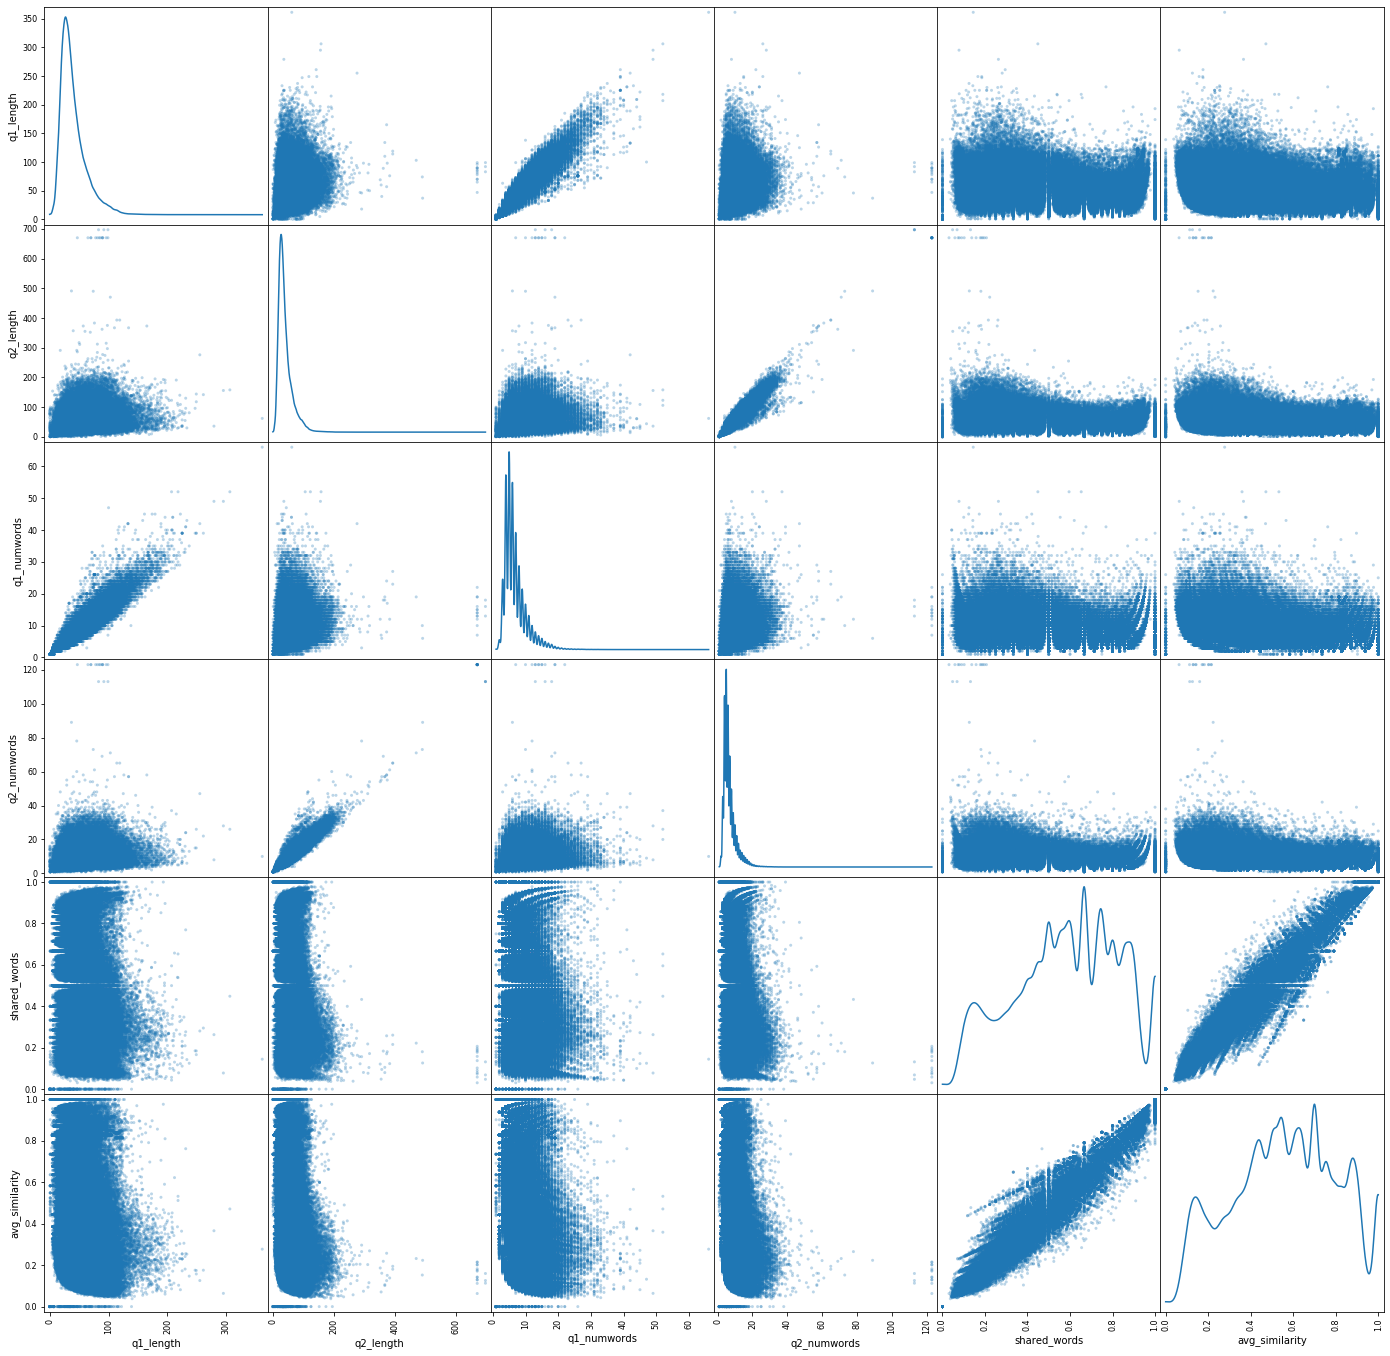

In [0]:
pd.plotting.scatter_matrix(feature_df[['q1_length', 'q2_length', 'q1_numwords', 'q2_numwords', \
            'shared_words', 'avg_similarity']], alpha = 0.3, figsize = (24,24), diagonal = 'kde');

We can observe average similarity is correlated well with the shared normalized words.


# **Normalize Features between 0 and 1**

In [0]:
## Scale the feature set to same min max values as our word2vec data scores ranges between -0.25 to 0.25
# min_range = round(np.min(mean_sentence_vector))
# max_range = round(np.max(mean_sentence_vector))

scale = MinMaxScaler(feature_range = (0, 1))
scale.fit(feature_df[['q1_length', 'q2_length', 'q1_numwords', 'q2_numwords', \
                      'shared_words', 'avg_similarity']])
Xfeature = scale.transform(feature_df[['q1_length', 'q2_length', 'q1_numwords', 'q2_numwords', \
                                       'shared_words', 'avg_similarity']])

print  ("Scaled Feature Min Value: ", np.min(Xfeature))
print  ("Scaled Feature Max Value: ", np.max(Xfeature))
print ("Shape of Feature Matrix:" , Xfeature.shape)

Scaled Feature Min Value:  0.0
Scaled Feature Max Value:  1.0000000000000002
Shape of Feature Matrix: (404290, 6)


In [0]:
#Add vector based cosine distance as a feature

q1_vec = compute_sentence_vec(df_train['question1'], w2v)
q2_vec = compute_sentence_vec(df_train['question2'], w2v)

# df_train['q1_vec'] = q1_vec
# df_train['q2_vec'] = q2_vec

In [0]:
#@title
print ("Shape of cosine similiarty", cosine_sim.shape)
#print ("Shape of word2vec Feature Matrix:" , mean_sentence_vector.shape)

## Combine
combined_feature_vector = np.hstack((mean_sentence_vector, Xfeature))
print ("Shape of Combined Feature Matrix:" , combined_feature_vector.shape)
#print "Shape of Training labels", len(train_labels)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(Xfeature, train_labels, test_size=0.25, random_state=3)

In [0]:
## Logistic Regression
print ("==================Logistic Regression Model============================================")
LR = LogisticRegression(C=1.0, penalty='l1')
LR.fit(X_train, y_train)
y_preds = LR.predict(X_valid)
print ("Logistic Regression Model predictive accuracy:", metrics.accuracy_score(y_preds, y_valid))
print ("Logistic Regression Model  F1 score:", metrics.classification_report(y_preds, y_valid))
print ("Logistic Regression Model log loss:", metrics.log_loss(y_preds, y_valid))
print ('\n')

print ("==================Gaussian Naive Bayes============================================")
GNB = GaussianNB()
GNB.fit(X_train, y_train)
y_preds = GNB.predict(X_valid)
print ("Gaussian Naive Bayes Model predictive accuracy:", metrics.accuracy_score(y_preds, y_valid))
print ("Gaussian Naive Bayes Model  F1 score:", metrics.classification_report(y_preds, y_valid))
print ("Gaussian Naive Bayes Model log loss:", metrics.log_loss(y_preds, y_valid))
print ('\n')

==================Logistic Regression Model============================================


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Model predictive accuracy: 0.6559219573971288
Logistic Regression Model  F1 score:               precision    recall  f1-score   support

           0       0.77      0.71      0.74     69750
           1       0.45      0.54      0.49     31323

    accuracy                           0.66    101073
   macro avg       0.61      0.62      0.62    101073
weighted avg       0.67      0.66      0.66    101073

Logistic Regression Model log loss: 11.884195099752308


==================Gaussian Naive Bayes============================================
Gaussian Naive Bayes Model predictive accuracy: 0.6626200864721538
Gaussian Naive Bayes Model  F1 score:               precision    recall  f1-score   support

           0       0.58      0.84      0.68     43897
           1       0.81      0.53      0.64     57176

    accuracy                           0.66    101073
   macro avg       0.69      0.68      0.66    101073
weighted avg       0.71      0.66      0.66    101073

In [0]:
print ("==================Support Vector Machines============================================")
sv = svm.SVC(C=1.0, kernel='linear')
sv.fit(X_train, y_train)
y_preds = sv.predict(X_valid)
print ("Support Vector Machine Model predictive accuracy:", metrics.accuracy_score(y_preds, y_valid))
print ("Support Vector Machine F1 score:", metrics.classification_report(y_preds, y_valid))
print ("Support Vector Machine log loss:", metrics.log_loss(y_preds, y_valid))
print ('\n')

==================Support Vector Machines============================================


In [0]:
print ("==================RandomForestClassifier============================================")
RF = RandomForestClassifier(n_estimators=100, max_depth=10, criterion = 'entropy')
RF.fit(X_train, y_train)
y_preds = RF.predict(X_valid)
print ("Random Forest Classifier Model predictive accuracy:", metrics.accuracy_score(y_preds, y_valid))
print ("Random Forest Classifier F1 score:", metrics.classification_report(y_preds, y_valid))
print ("Random Forest Classifier log loss:", metrics.log_loss(y_preds, y_valid))
print ('\n')

In [0]:
#@title
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,ExtraTreesClassifier 
from sklearn import preprocessing

names = ["Nearest Neighbors", "XGBoost",
         "Decision Tree", "Random Forest","ExtraTreesClassifier", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(10),
    xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=100,max_features=2),
    ExtraTreesClassifier(max_depth=5,n_estimators=100,max_features=2),
    ]

df = pd.read_csv('/content/drive/My Drive/FINAL DESTINATION/DATA/train.csv',encoding='utf-8').iloc[:,1:]
import pandas as pd

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

Z= df.drop(['question1','question2'], 1)
print (Z.head())
Z=clean_dataset(Z)
y = Z['is_duplicate']
X = Z.drop(['is_duplicate'], 1)

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=Z.is_duplicate,random_state=42)
feat_test=DecisionTreeClassifier(min_samples_split=0.1)
feat_test.fit(X_train, y_train)
print ("\n\nImportant Features:\n",feat_test.feature_importances_)

# iterate over classifiers
for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print (name+' Score:',score)
        prediction1 = clf.predict(X_test)
        np.set_printoptions(precision=2)